# Braille Text Translator

## 1. Enhance original image

### Import libraries

In [0]:
import sys
import cv2
import scipy
import random
import imageio
import numpy as np
import zipfile as zf
import matplotlib.pyplot as plt

from scipy import ndimage
from imageio import imread
from skimage.feature import hog
from scipy.ndimage import shift
from sklearn.metrics import accuracy_score
from PIL import Image, ImageDraw, ImageFont
from skimage.util import random_noise, invert
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

### Utilitary functions used in the program

In [0]:
# Normalizes image pixels between 0 and 255
def normalize(img):
	imin = np.min(img)
	imax = np.max(img)

	return (((img - imin)/(imax - imin)) * 255).astype(np.float)

# Prints image with minimum value equal to 0 and maximum to 255
def printNormalizedImage(img):
	plt.figure(figsize=(16,8)) 
	plt.imshow(mat, cmap="gray", vmin=0, vmax=255)
  
# Prints image with matplotlib defaults  
def printImage(img):
	plt.figure(figsize=(16,8)) 
	plt.imshow(mat, cmap="gray")

# Median difference filter, highlights the shadow pixels
def filter(I, n):
	m = n//2
	J = np.empty(I.shape, dtype=np.float)
	N, M = I.shape
	I = np.pad(I, ((m, m), (m, m)), 'symmetric')

	for i in range(N):
		for j in range(M):
			sub = I[i+m:(i+m+n), j+m:(j+m+n)]
			med = np.median(np.ravel(sub)) # gets median
			J[i, j] = abs(I[i+m, j+m] - med) # applies the difference
	return J

# Applies mean filter to image I
def MeanFilter(I, n):
	m = n//2
	J = np.empty(I.shape, dtype=np.float) # the answer
	N, M = I.shape
	I = np.pad(I, ((m, m), (m, m)), 'symmetric')
	for	i in range(N):
		for j in range(M):
			# copies the matrix to sub
			sub = I[i+m:(i+m+n), j+m:(j+m+n)]
			J[i, j] = np.mean(np.ravel(sub)) # get mean of the linearized list
	return J

### Enhancing image

1.png


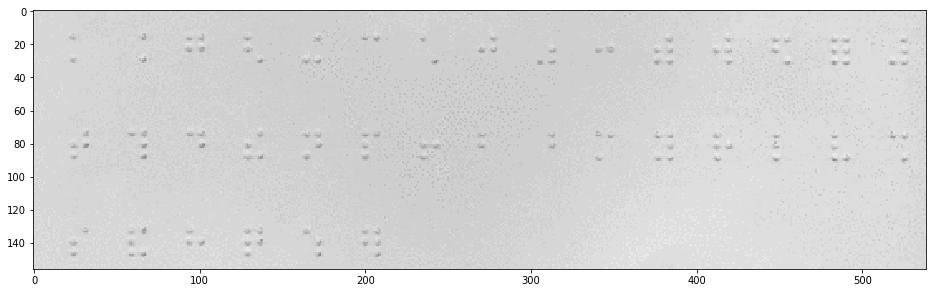

In [32]:
filename = str(input()).rstrip() # filename of the input image
image = imageio.imread(filename)
matrix = np.array(image, copy=True, dtype=np.float)

N, M, _ = matrix.shape

sys.setrecursionlimit(10 * N * M)

# Transform RGB to gray scale
for i in range(N):
	for j in range(M):
		matrix[i, j, 0] = matrix[i, j, 0] * 0.2989 + matrix[i, j, 1] * 0.5870 + matrix[i, j, 2] * 0.1140
    
matrix = matrix[:, :, 0:1].squeeze()

# Plot original image
mat = matrix.astype(np.uint8)
printNormalizedImage(mat)

matrix = normalize(matrix)
dots_matrix = filter(matrix, 21) # Applies filter to normalized matrix
dots_matrix = normalize(dots_matrix)

# Smooth image using mean filter, to reduce noise
dots_matrix = MeanFilter(dots_matrix, 3)

## 2. Transform into binary matrix

### Thresholding image

In [0]:
# Thresholding step, 30 is arbitrary value derived from testing with images, but independent of input image gray scale
for i in range(N):
	for j in range(M):
		dots_matrix[i, j] = 0 if dots_matrix[i, j] < 30 else 1

Now we want to ignore some white regions, which must not be seen as braillee circles

To do that, we can use image description of our pattern, and use the comparison result to decide to keep or ignore some region 

The parameters that must be considered to describe the circles are the colour description, its size in pixels, and its centrality in the image

To describe our pattern, we can calculate the mean of the histograms, using centrality as a weight

The size of the regions can be used to already discard some regions beforehand (this can be applied optionally) 

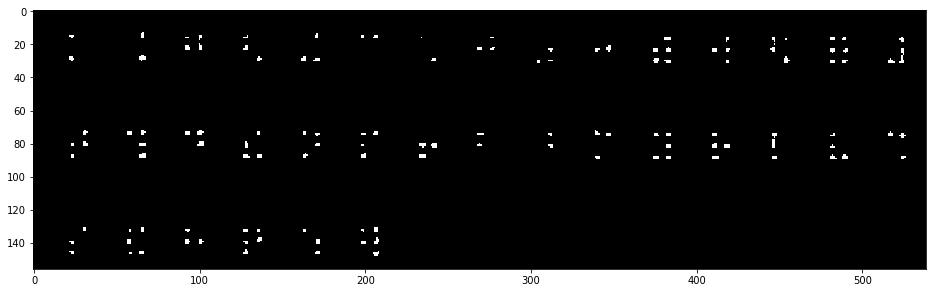

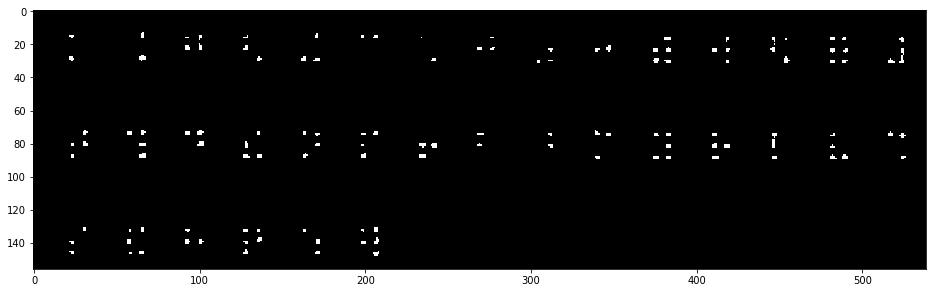

In [34]:
# Erode the regions to calculate circles
dots_matrix = ndimage.binary_erosion(dots_matrix)

# Plot segmented image
mat = dots_matrix.astype(np.uint8)
printImage(mat)

def pointsInComponent(i, j, pts):
	vis[i, j] = 1
	pts.append((i, j))
	if i + 1 < N and vis[i+1, j] == 0 and dots_matrix[i+1, j] == 1: pointsInComponent(i+1, j, pts)
	if i - 1 >=0 and vis[i-1, j] == 0 and dots_matrix[i-1, j] == 1: pointsInComponent(i-1, j, pts)
	if j + 1 < M and vis[i, j+1] == 0 and dots_matrix[i, j+1] == 1: pointsInComponent(i, j+1, pts)
	if j - 1 >=0 and vis[i, j-1] == 0 and dots_matrix[i, j-1] == 1: pointsInComponent(i, j-1, pts)

vis = np.zeros((N, M))

# Retrieve components (white regions) and its pixels
comp = []
for i in range(N):
	for j in range(M):
		if vis[i, j] == 0 and dots_matrix[i, j] == 1:
			comp.append([])
			pointsInComponent(i, j, comp[-1])

# Calculate histograms of each region using list comprehension
histograms = [
	np.histogram(np.array([matrix[x] for x in pts]), bins=256, range=(0, 255))[0] 
	for pts in comp
]

sz = np.median([len(x) for x in comp])
# histogram description of braille circle, it is calculated as weighted mean of the histograms of white regions, in which the weight is it's centrality
desc = []
for c in range(256):
	desc.append(0)
	sum = 0 # sums of weights
	for i in range(len(comp)):
		if abs(len(comp[i]) - sz) > sz: continue 
		p, q = comp[i][0]
		w = np.min([(p+1), (N - p+1), (q+1), (M - q + 1)]) # weight of the region, its centrality
		w = w/(len(comp))
		sum += w
		desc[c] += w * histograms[i][c]
	desc[c] /= sum

# Flood fill algorithm to paint unwanted white regions
def paintBlack(i, j):
	dots_matrix[i, j] = 0
	if i + 1 < N and dots_matrix[i+1, j] == 1: paintBlack(i+1, j)
	if i - 1 >=0 and dots_matrix[i-1, j] == 1: paintBlack(i-1, j)
	if j + 1 < M and dots_matrix[i, j+1] == 1: paintBlack(i, j+1)
	if j - 1 >=0 and dots_matrix[i, j-1] == 1: paintBlack(i, j-1)

# CV histogram correlation function
def compare(a, b):
	return cv2.compareHist(np.array(a).astype('float32'), np.array(b).astype('float32'), cv2.HISTCMP_CORREL)

# Euclidean distance comparison function
def euclideanDistance(a, b):
	return (np.sum((np.array(a) - np.array(b))**2)/256)**(1/2)

errors = []
for i in range(len(histograms)):
	errors.append(compare(desc, histograms[i]))
	if compare(desc, histograms[i]) < 0 or euclideanDistance(desc, histograms[i]) > 1: #if correlation between the two histograms is less than 0.05, paint it black
		print(euclideanDistance(desc, histograms[i]), end=' ')
		print(compare(desc, histograms[i]))	
		paintBlack(comp[i][0][0], comp[i][0][1])

# Plot segmented image
mat = dots_matrix.astype(np.uint8)
printImage(mat)

## 3. Determine radius of a braille circle

In [26]:
# This part will calculate the average radius
radius = 0.0 
for i in range(len(comp)):
	lo = N
	for pt in comp[i]: lo = min(lo, pt[0])
	hi = 0
	for pt in comp[i]: hi = max(hi, pt[0])

	v = hi - lo + 1
	lo = M
	for pt in comp[i]: lo = min(lo, pt[1])
	hi = 0
	for pt in comp[i]: hi = max(hi, pt[1])

	v = max(v, hi - lo + 1)
	radius += v

radius /= len(comp)
print(radius)

5.370454545454545


## 4. Segment image into blocks

## 5. For each block, determine which letter it represents


###Training model to classify patterns into letters

In [0]:
# Reading train images

zf.ZipFile('media.zip').extractall()

images = []
for i in range(1, 27):
  images.append(imread("media/images/train/" + str(i) + ".png")[:,:,0])

In [0]:
# Function to apply noise and generate more training images
def gen_data(base_image, quantity, label, data, target, radius=4):
  for i in range(quantity):
    data.append(shift(base_image, [random.randint(-1*radius,1*radius), random.randint(-1*radius,1*radius)]))
    target.append(label)

In [0]:
X = []
Y = []

for i in range(26):
  gen_data(invert(images[i]), 30 , i+1, X, Y)

x = []

for i in X:
  x.append(hog(i, block_norm='L2-Hys',  pixels_per_cell=(2,2), visualize=False))
  #x.append(i.reshape((60*40)))

x = np.asarray(x)
y = np.asarray(Y)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, tol=1e-3)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy for labelled test dataset:", accuracy_score(y_test, y_pred))

Accuracy for labelled test dataset: 0.7564102564102564


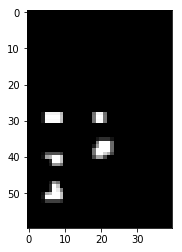

In [69]:
test_k = imageio.imread('media/images/test/test_q.png')
plt.imshow(test_k)

from skimage.transform import resize

resized = resize(test_k, (60,40))[:,:,0]

plt.imshow(resized, cmap="gray")

resized.shape


hogs_test = hog(resized, block_norm='L2-Hys',  pixels_per_cell=(2,2), visualize=False)

In [70]:
clf.predict([hogs_test])

array([19])

## 6. Insert corresponding letter on top of the block it represents

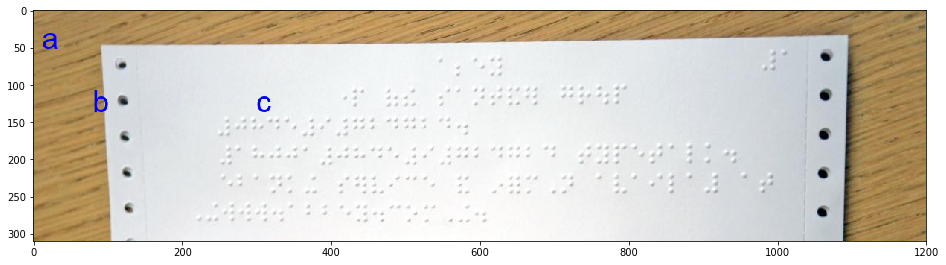

In [31]:
## Draws the letters on top of the boxes
positions = [(12, 15, 'a'), (80, 100, 'b'), (300, 100, 'c')]

img = Image.open(filename).convert('RGBA')
d = ImageDraw.Draw(img)
fnt = ImageFont.truetype('media/fonts/arial.ttf', 40)

for x, y, c in positions:
	d.text((x, y), "" + c, font=fnt, fill=(0, 0, 255, 255))

plt.figure(figsize=(16,8))
plt.imshow(img)